In [1]:
# Facial Expression Classification

# You will provided a training dataset, so you can design your model and propose a solution you think is the best for this case.

# Overall there are 8 different facial expressions in a dataset. Of course in real-world it would be a much bigger number, but even this number is not that easy to correctly identify. So your dataset contains the following classes of facial expressions:


# '0' : 'Anger'
# '1' : 'Contempt'
# '2' : 'Disgust'
# '3' : 'Fear'
# '4' : 'Happy'
# '5' : 'Neutral'
# '6' : 'Sad'
# '7' : 'Surprise'

# This example is a short guideline with a model to show you how to get a correct submission file.

# BUT REMEMBER: Provided model shows a result arruracy below 50% which is NOT sufficient for a final result.

In [2]:
import os
import torch
import pandas as pd
from torch import nn
from PIL import Image
from torchvision import transforms
from IPython.display import clear_output
from torchvision.transforms import v2

transform = transforms.Compose([
                               transforms.PILToTensor(),
                               v2.ToDtype(torch.float32, scale=True),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
!gdown 1jjGULBTHgxfpgriRWW0vRm99qMNUGlzD

Downloading...
From (original): https://drive.google.com/uc?id=1jjGULBTHgxfpgriRWW0vRm99qMNUGlzD
From (redirected): https://drive.google.com/uc?id=1jjGULBTHgxfpgriRWW0vRm99qMNUGlzD&confirm=t&uuid=53d2e889-f498-44db-aeda-9db9c6b87f82
To: /content/test_dataset.zip
100% 52.6M/52.6M [00:01<00:00, 46.1MB/s]


In [4]:
!gdown 1MBczmIad-re3SOf_ml6d7BTCNDkCUAFR

Downloading...
From (original): https://drive.google.com/uc?id=1MBczmIad-re3SOf_ml6d7BTCNDkCUAFR
From (redirected): https://drive.google.com/uc?id=1MBczmIad-re3SOf_ml6d7BTCNDkCUAFR&confirm=t&uuid=f32a3389-9df0-40cb-acba-38610d639790
To: /content/train_dataset.zip
100% 212M/212M [00:04<00:00, 51.8MB/s]


In [5]:
!unzip test_dataset.zip
clear_output()

In [6]:
!unzip train_dataset.zip
clear_output()

In [7]:
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 39.0 MB/s eta 0:00:00


In [8]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [9]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

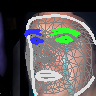

In [47]:
import mediapipe as mp
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')

options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=2)

detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("/content/test/images/10370.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

array([[[  0,   0,   2],
        [  0,   0,   2],
        [  0,   0,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   2],
        [  0,   0,   2],
        [  0,   0,   2],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 99,  99,  99],
        [  2,   2,   2],
        [  0,   0,   0],
        ...,
        [122,  97,  90],
        [124,  99,  94],
        [124, 101,  95]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  2,   2,   2],
        ...,
        [127, 100,  93],
        [128, 103,  96],
        [128, 103,  96]],

       [[  0,   0,   0],
        [  2,   2,   2],
        [  0,   0,   0],
        ...,
        [130, 103,  94],
        [129, 104,  97],
        [128, 103,  96]]], dtype=uint8)
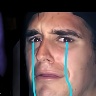

In [50]:
image.numpy_view()

In [36]:
detection_result.face_blendshapes

[[Category(index=0, score=5.162095476407558e-06, display_name='', category_name='_neutral'),
  Category(index=1, score=0.22077958285808563, display_name='', category_name='browDownLeft'),
  Category(index=2, score=0.15250913798809052, display_name='', category_name='browDownRight'),
  Category(index=3, score=0.00624827528372407, display_name='', category_name='browInnerUp'),
  Category(index=4, score=0.007714663632214069, display_name='', category_name='browOuterUpLeft'),
  Category(index=5, score=0.03385905548930168, display_name='', category_name='browOuterUpRight'),
  Category(index=6, score=2.315387064300012e-05, display_name='', category_name='cheekPuff'),
  Category(index=7, score=5.579902335739462e-07, display_name='', category_name='cheekSquintLeft'),
  Category(index=8, score=1.6904937183426227e-06, display_name='', category_name='cheekSquintRight'),
  Category(index=9, score=0.06423023343086243, display_name='', category_name='eyeBlinkLeft'),
  Category(index=10, score=0.0634

[5.162095476407558e-06,
 0.22077958285808563,
 0.15250913798809052,
 0.00624827528372407,
 0.007714663632214069,
 0.03385905548930168,
 2.315387064300012e-05,
 5.579902335739462e-07,
 1.6904937183426227e-06,
 0.06423023343086243,
 0.06346447765827179,
 0.2130013108253479,
 0.25210344791412354,
 0.0009787882445380092,
 0.7259523272514343,
 0.6987514495849609,
 0.006011337507516146,
 0.048292145133018494,
 0.037889741361141205,
 0.45194366574287415,
 0.2865297496318817,
 0.013193189166486263,
 0.011504748836159706,
 8.062816777965054e-05,
 0.00020425688126124442,
 0.003906708676367998,
 0.00031071537523530424,
 0.0007166430004872382,
 0.00827470887452364,
 0.0020388003904372454,
 0.013216875493526459,
 0.016781650483608246,
 0.00011142036237288266,
 0.0006057014688849449,
 0.00010117334750248119,
 0.0002962074941024184,
 0.24276047945022583,
 0.02562795765697956,
 0.001791957183741033,
 0.0005971802747808397,
 0.06472237408161163,
 0.0035856140311807394,
 0.14700117707252502,
 0.01954039

In [12]:
df = pd.read_csv('/content/train/train_dataset.csv')

In [13]:
df

,image_name,image_label
0,images/11731.png,7
1,images/2763.png,1
2,images/20957.png,5
3,images/15221.png,7
4,images/16814.png,4
...,...,...
20204,images/18464.png,4
20205,images/1941.png,4
20206,images/12660.png,2
20207,images/14385.png,5


In [14]:
df['image_label'].value_counts()

,count
image_label,
7,3317
0,2765
4,2676
2,2610
1,2347
3,2345
6,2233
5,1916


In [15]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 1: Load the CSV file containing image names and labels
csv_file_path = 'train/train_dataset.csv'
df = pd.read_csv(csv_file_path)

# Step 2: Create train and validation splits
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['image_label'])

# Step 3: Create new directories for train and validation datasets
base_dir = 'dataset'
os.makedirs(os.path.join(base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val'), exist_ok=True)

# Step 4: Create sub-directories for each class in train and val directories
for label in df['image_label'].unique():
    os.makedirs(os.path.join(base_dir, 'train', str(label)), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'val', str(label)), exist_ok=True)

# Step 5: Move the images to their respective directories
for _, row in train_df.iterrows():
    src = os.path.join('train', row['image_name'])
    dst = os.path.join(base_dir, 'train', str(row['image_label']), row['image_name'].split('/')[-1])
    shutil.copy(src, dst)

for _, row in val_df.iterrows():
    src = os.path.join('train', row['image_name'])
    dst = os.path.join(base_dir, 'val', str(row['image_label']), row['image_name'].split('/')[-1])
    shutil.copy(src, dst)

In [39]:
def get_batch_landmarks(batch_images, landmark_extractor):
    """
    Get a batch of landmarks for a batch of images.

    Args:
        batch_images (torch.Tensor): A batch of images.
        landmark_extractor (nn.Module): The landmark extractor model.

    Returns:
        torch.Tensor: A batch of landmarks.
    """
    # Extract landmarks from each image in the batch
    batch_landmarks = []
    for image in batch_images:
        landmarks = detector.detect(image)
        batch_landmarks.append([category.score for category in detection_result.face_blendshapes[0]])

    # Stack the landmarks into a batch
    batch_landmarks = torch.cat(batch_landmarks, dim=0)

    return batch_landmarks

# Submission

In [20]:
import os
import sys

from tqdm import tqdm
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms, datasets

from networks.DDAM import DDAMNet
import torch.nn.functional as F
from sam import SAM
eps = sys.float_info.epsilon


class ImbalancedDatasetSampler(data.sampler.Sampler):
    def __init__(self, dataset, indices: list = None, num_samples: int = None):
        self.indices = list(range(len(dataset))) if indices is None else indices
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        if isinstance(dataset, datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torch.utils.data.Subset):
            return [dataset.dataset.imgs[i][1] for i in dataset.indices]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

class AttentionLoss(nn.Module):
    def __init__(self, ):
        super(AttentionLoss, self).__init__()

    def forward(self, x):
        num_head = len(x)
        loss = 0
        cnt = 0
        if num_head > 1:
            for i in range(num_head-1):
                for j in range(i+1, num_head):
                    mse = F.mse_loss(x[i], x[j])
                    cnt = cnt+1
                    loss = loss+mse
            loss = cnt/(loss + eps)
        else:
            loss = 0
        return loss


def run_training(batch_size, num_workers, lr = 0.01, num_epochs =30):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.enabled = True

    model = DDAMNet(num_class=8, num_head=2, pretrained = False)
    model.to(device)

    data_transforms = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
                transforms.RandomAffine(20, scale=(0.8, 1), translate=(0.2, 0.2)),
            ], p=0.7),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=1, scale=(0.05, 0.05)),
        ])


    train_dataset = datasets.ImageFolder('/content/dataset/train', transform = data_transforms)
    #train_subset = torch.utils.data.Subset(train_dataset, range(0, len(train_dataset) // 10))

    print('Whole train set size:', train_dataset.__len__())
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               num_workers = num_workers,
                                               sampler=ImbalancedDatasetSampler(train_dataset),
                                               shuffle = False,
                                               pin_memory = True)

    data_transforms_val = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])



    val_dataset = datasets.ImageFolder('/content/dataset/val', transform = data_transforms_val)

    print('Validation set size:', val_dataset.__len__())

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = batch_size,
                                               num_workers = num_workers,
                                               shuffle = False,
                                               pin_memory = True)


    criterion_cls = torch.nn.CrossEntropyLoss().to(device)
    criterion_at = AttentionLoss()
    params = list(model.parameters())
    #optimizer = torch.optim.Adam(params,args.lr,weight_decay = 0)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.6)

    optimizer = SAM(model.parameters(), torch.optim.Adam, lr=lr, rho=0.05, adaptive=False, )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

    best_acc = 0
    for epoch in tqdm(range(1, num_epochs + 1)):
        running_loss = 0.0
        correct_sum = 0
        iter_cnt = 0
        model.train()

        for (imgs, targets) in train_loader:
            iter_cnt += 1

            imgs = imgs.to(device)
            targets = targets.to(device)

            out,feat,heads = model(imgs)

            loss = criterion_cls(out,targets)  + 0.1*criterion_at(heads)

            optimizer.zero_grad()
            loss.backward()
            optimizer.first_step(zero_grad=True)


            imgs = imgs.to(device)
            targets = targets.to(device)

            out,feat,heads = model(imgs)

            loss = criterion_cls(out,targets)  + 0.1*criterion_at(heads)

            optimizer.zero_grad()
            loss.backward()
            optimizer.second_step(zero_grad=True)
            running_loss += loss
            _, predicts = torch.max(out, 1)
            correct_num = torch.eq(predicts, targets).sum()
            correct_sum += correct_num

        acc = correct_sum.float() / float(train_dataset.__len__())
        running_loss = running_loss/iter_cnt
        tqdm.write('[Epoch %d] Training accuracy: %.4f. Loss: %.3f. LR %.6f' % (epoch, acc, running_loss,optimizer.param_groups[0]['lr']))

        with torch.no_grad():
            running_loss = 0.0
            iter_cnt = 0
            bingo_cnt = 0
            sample_cnt = 0
            model.eval()
            for imgs, targets in val_loader:

                imgs = imgs.to(device)
                targets = targets.to(device)
                out,feat,heads = model(imgs)

                loss = criterion_cls(out,targets)  + 0.1*criterion_at(heads)

                running_loss += loss
                iter_cnt+=1
                _, predicts = torch.max(out, 1)
                correct_num  = torch.eq(predicts,targets)
                bingo_cnt += correct_num.sum().cpu()
                sample_cnt += out.size(0)

            running_loss = running_loss/iter_cnt
            #scheduler.step()

            acc = bingo_cnt.float()/float(sample_cnt)
            acc = np.around(acc.numpy(),4)
            best_acc = max(acc,best_acc)
            tqdm.write("[Epoch %d] Validation accuracy:%.4f. Loss:%.3f" % (epoch, acc, running_loss))
            tqdm.write("best_acc:" + str(best_acc))

            if  acc > 0.50:
                torch.save({'iter': epoch,
                            'model_state_dict': model.state_dict(),
                             'optimizer_state_dict': optimizer.state_dict(),},
                            os.path.join('checkpoints_ver2.0', "affecnet8_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
                tqdm.write('Model saved.')
        scheduler.step()
if __name__ == "__main__":
    run_training(128, 2)

Whole train set size: 16167
Validation set size: 4042


  0%|          | 0/30 [03:14<?, ?it/s]

[Epoch 1] Training accuracy: 0.1176. Loss: 3.352. LR 0.010000


  0%|          | 0/30 [03:22<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  3%|▎         | 1/30 [03:22<1:37:44, 202.24s/it]

[Epoch 1] Validation accuracy:0.1244. Loss:16.948
best_acc:0.1244


  3%|▎         | 1/30 [06:32<1:37:44, 202.24s/it]

[Epoch 2] Training accuracy: 0.1194. Loss: 2.501. LR 0.009800


  7%|▋         | 2/30 [06:39<1:33:03, 199.40s/it]

[Epoch 2] Validation accuracy:0.1084. Loss:2.866
best_acc:0.1244


  7%|▋         | 2/30 [09:49<1:33:03, 199.40s/it]

[Epoch 3] Training accuracy: 0.1240. Loss: 2.339. LR 0.009604


 10%|█         | 3/30 [09:57<1:29:26, 198.77s/it]

[Epoch 3] Validation accuracy:0.1306. Loss:2.606
best_acc:0.1306


 10%|█         | 3/30 [13:07<1:29:26, 198.77s/it]

[Epoch 4] Training accuracy: 0.1305. Loss: 2.245. LR 0.009412


 13%|█▎        | 4/30 [13:15<1:25:53, 198.21s/it]

[Epoch 4] Validation accuracy:0.1338. Loss:2.245
best_acc:0.1338


 13%|█▎        | 4/30 [16:24<1:25:53, 198.21s/it]

[Epoch 5] Training accuracy: 0.1407. Loss: 2.207. LR 0.009224


 17%|█▋        | 5/30 [16:32<1:22:29, 197.98s/it]

[Epoch 5] Validation accuracy:0.1368. Loss:2.194
best_acc:0.1368


 17%|█▋        | 5/30 [16:40<1:23:21, 200.06s/it]


KeyboardInterrupt: 

In [ ]:
def submission_file_generation(images_path, model_weights_path):

  model = DDAMNet(num_class=8, num_head=2, pretrained = False)
  model.load_state_dict(torch.load('model-fec.pt', weights_only=True))
  model.eval()
  result = {'ID': [], 'Target': []}

  for img_ in os.listdir(images_path):
    image_transformed = transform(Image.open(images_path + img_))
    with torch.no_grad():
      output = model(image_transformed.unsqueeze(0))
      ps = torch.exp(output)
      topk, topclass = ps.topk(1, dim = 1)
    result['ID'].append(img_)
    result['Target'].append(topclass.numpy().squeeze())

  return pd.DataFrame.from_records(result).to_csv('result_fce.csv', index=False)

In [ ]:
path_to_images = 'test/images/'
path_to_model = 'model-fce.pt'

submission_file_generation(path_to_images, path_to_model)

FileNotFoundError: [Errno 2] No such file or directory: 'model-fec.pt'

In [ ]:
pd.read_csv('result_fce.csv')

,ID,Target
0,3381.png,1
1,9085.png,7
2,6397.png,3
3,23220.png,6
4,7112.png,7
...,...,...
5048,7804.png,0
5049,9112.png,2
5050,13567.png,1
5051,16193.png,4
